# Reducing variability in along-tract analysis with diffusion profile realignment

In this example, we will load up 150 streamlines from a synthetic dataset.  
They are however unaligned, so we will simulate different subject by truncating their endpoints, realign everything together and only keep  
the sections where at least 75% of the bundles are overlapping

In [1]:
import sys
sys.path.append('dpr')

# This is the main functions we will need, there are a few more that might be useful for finer grained control inside register.py
from register import align_bundles, resample_bundles_to_same, flip_fibers, truncate

# This contains a few functions to load up the data from text file
# but we won't need them in this example as I did it already
from utils import read_per_line, strip_first_col, strip_header

A few import needed for this example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time
%matplotlib inline 

Load up the data
+ This will most likely be the most difficult step, getting your data in the right formatt
+ You need to load everything as a 2D array of size (number of subjects x along-tract metric) in the same coordinate system
    + More on that a bit later, but every subject will need to have the same starting and ending coordinate system for everything to make sense

In [3]:
bundles = np.loadtxt('datasets/bundles.txt')
bundles_cut = np.loadtxt('datasets/bundles_cut.txt')

with open('datasets/coordinates.pkl', 'rb') as f:
    coordinates = pickle.load(f)

+ Each bundle is represented as a line in a 2D array
    + There are 150 bundles with the longest having 208 points
    + Shorter elements are represented using nans to pad them to the same size
+ The coordinates are represented as a list of 150 elements, which contains 2D arrays of coordinates in x, y and z
    + They are not strictly needed for the algorithm, but allow us to draw figures using the original coordinates
    + They are also needed to make sure fiber bundles all share the same point of origin in the first place

In [4]:
print('Shape of the bundles: {}, number of bundles: {} and shape of the coordinates: {}'.format(bundles.shape, len(coordinates), coordinates[0].shape))

Shape of the bundles: (150, 208), number of bundles: 150 and shape of the coordinates: (184, 3)


We first need to ensures everything is at the same starting point and 'going the same way'
+ For that we need the xyz coordinates also
+ This may already be taken care of by your softwar,e for example ExploreDTI already keeps all subjects in the same coordinate system when the metrics are extracted

In [5]:
flipped_bundles = flip_fibers(bundles, coordinates)
flipped_bundles_cut = flip_fibers(bundles_cut, coordinates)

We assume that every subject uses the same coordinate system, else we would be realigning 3D coordinates which do nto even match
+ The top row for the original bundles has a coordinate mismach, which we fixed by flipping everything in the same way on the bottom
+ Note how is it not immediatly obvious on the cut bundles at first

Text(0.5,1,'Flipped, but not aligned, cut bundles')

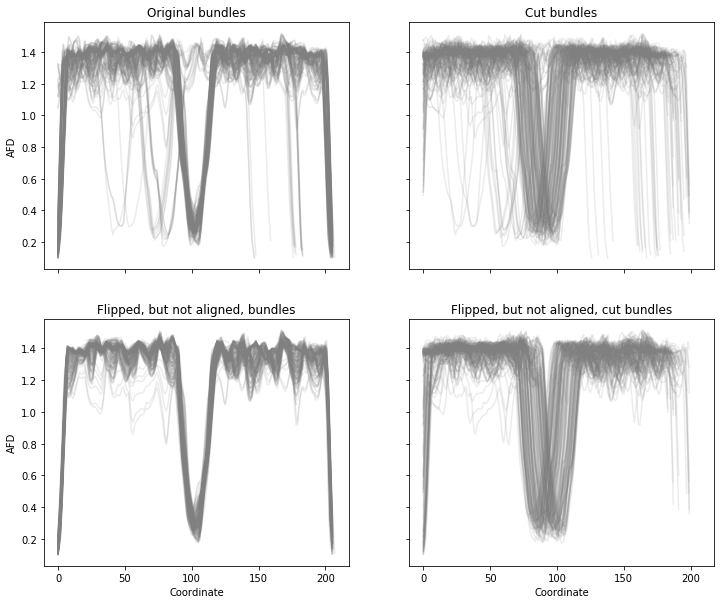

In [6]:
all_bundles = bundles, bundles_cut, flipped_bundles, flipped_bundles_cut

f, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for bund, ax in zip(all_bundles, axs.ravel()):
    for b in bund:
        ax.plot(b, alpha=0.15, color='gray');

for ax in axs[1]:
    ax.set_xlabel('Coordinate')
for ax in axs[:,0]:
    ax.set_ylabel('AFD')
    
axs[0,0].set_title('Original bundles')
axs[1,0].set_title('Flipped, but not aligned, bundles')
axs[0,1].set_title('Cut bundles')
axs[1,1].set_title('Flipped, but not aligned, cut bundles')

And now we realign everything
+ The function returns both the aligned bundles and the shift (in number of points) applied to each of them
+ A positive value means a shift to the right and a negative value is for a shift to the left

In [7]:
start = time()
aligned_bundles_cut, shifts = align_bundles(bundles_cut)
print('Total runtime was {} seconds'.format(time() - start))

Total runtime was 3.9507369995117188 seconds


At this point we would be basically done and can save all of that to a text file if we want.  
+ However we can do some more processing to only select regions of the bundles which have enough overlapping subjects.  

We now plot the realigned bundles, but we first remove all of the useless padding

In [8]:
aligned_bundles_cut = truncate(aligned_bundles_cut, mode='longest')

Text(0.5,1,'Realigned cut bundles')

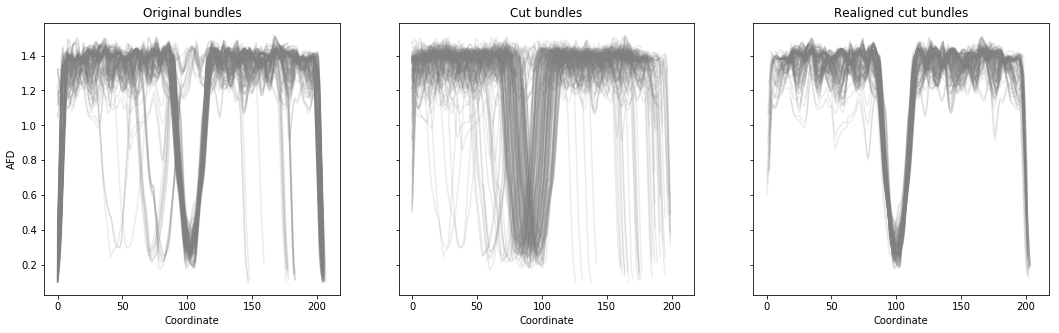

In [9]:
all_bundles = bundles, bundles_cut, aligned_bundles_cut

f, axs = plt.subplots(1, 3, figsize=(18,5), sharex=True, sharey=True)
for bund, ax in zip(all_bundles, axs.ravel()):
    for b in bund:
        ax.plot(b, alpha=0.15, color='gray');
    ax.set_xlabel('Coordinate')
        
axs[0].set_ylabel('AFD')
    
axs[0].set_title('Original bundles')
axs[1].set_title('Cut bundles')
axs[2].set_title('Realigned cut bundles')

We can now remove more padding and keep only relevant portions
+ Remember that after realignment, the intrinsic coordinates of each bundle is different and we need to keep track of it to draw them correctly
+ Here we resample everything to 50 points and keep only portions where there is at least 75% of the bundles overlapping

In [10]:
bundles_truncated = truncate(aligned_bundles_cut, mode=75)
num_points = 50
resampled_cut = resample_bundles_to_same(bundles_truncated, num_points=num_points)

In [11]:
all_bundles = bundles, bundles_cut, bundles_truncated, resampled_cut

# They all have a different number of points, but we can keep track of their relative positioning
# with the shift matrix and the original coordinates in xyz if needed
for idx, bund in enumerate(all_bundles, start=1):
    print('Shape of bundle no. {}: {}'.format(idx, bund.shape))

Shape of bundle no. 1: (150, 208)
Shape of bundle no. 2: (150, 208)
Shape of bundle no. 3: (150, 171)
Shape of bundle no. 4: (150, 50)


Text(0.5,1,'Realigned and resampled bundles')

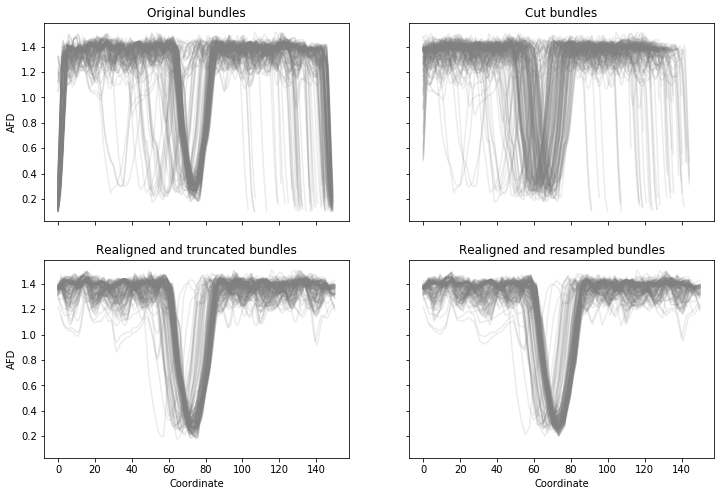

In [12]:
endpoints = np.isfinite(bundles_truncated).sum(axis=0)

f, axs = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
for bund, ax in zip(all_bundles, axs.ravel()):
    for idx, b in enumerate(bund):
        end = endpoints[idx]
        # this line ensures that when we draw the bundles, they all have the same coordinates 
        # even if they have a different number of points points
        coords = np.linspace(0, end, num=len(b), endpoint=True)
        ax.plot(coords, b, alpha=0.15, color='gray');
 
axs[1,0].set_xlabel('Coordinate')
axs[1,1].set_xlabel('Coordinate')
axs[0,0].set_ylabel('AFD')
axs[1,0].set_ylabel('AFD')
    
axs[0,0].set_title('Original bundles')
axs[0,1].set_title('Cut bundles')
axs[1,0].set_title('Realigned and truncated bundles')
axs[1,1].set_title('Realigned and resampled bundles')

Remember when extracting averaged metrics that missing portions are represented with Nans, so we must take that into account with specialized functions that ignore them
+ This is because Nans get propagated, showing only the portions where all of the subjects would be overlapping

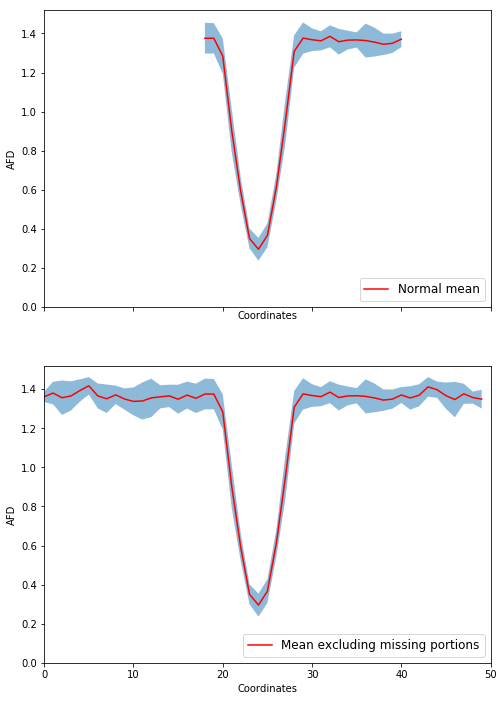

In [13]:
means = np.mean(resampled_cut, axis=0), np.nanmean(resampled_cut, axis=0)
stds = np.std(resampled_cut, axis=0), np.nanstd(resampled_cut, axis=0)
labels = 'Normal mean', 'Mean excluding missing portions'

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8, 12)) 
for ax, mean, std, label in zip(axes, means, stds, labels):
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.5)
    ax.plot(mean, color='r', label=label)
    ax.set_xlim(0, len(mean))
    ax.set_ylim(0, None)
    ax.legend(loc='lower right', fontsize=12)
    ax.set(ylabel='AFD', xlabel='Coordinates')

And that's pretty much it, if we want we can also store the realigned metrics in a text file for further processing in your environment of choice, such as R for example
+ Remember than Nans indicate coordinate location where a given subject is not present during further processing

In [14]:
# we keep 5 decimals, this is what the fmt option does
# Each line is a subject and each column is a point in the along-tract analysis
np.savetxt('bundle_realigned_truncated.txt', bundles_truncated, fmt='%1.5f')
np.savetxt('bundle_realigned_resampled.txt', resampled_cut, fmt='%1.5f')